In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
import random
from Main_functions import *

In [2]:
def pre_process(X_raw_T, X_raw_Test, Type = 'normalizing'):
    
    X_new_T = (X_raw_T - X_raw_T.mean(axis = 0))
    X_new_Test = (X_raw_Test - X_raw_T.mean(axis = 0))
    
    if Type == 'normalizing':
        std = X_new_T.std(axis = 0)
        for i in range(len(std)):
            if std[i] > 1e-3:
                X_new_T[:, i] /= std[i]
                X_new_Test[:, i] /= std[i]
        
    elif Type == 'center_scaling':
        Max = X_new_T.max(axis = 0)
        Min = X_new_T.min(axis = 0)
        for i in range(len(Max)):
            if Max[i] - Min[i] > 1e-3:
                X_new_T[:, i]  = (X_new_T[:, i] - Min[i])/(Max[i] - Min[i])
                X_new_Test[:, i]  = (X_new_Test[:, i] - Min[i])/(Max[i] - Min[i])
            else: 
                X_new_T[:, i]  = (X_new_T[:, i] - Min[i])
                X_new_Test[:, i]  = (X_new_Test[:, i] - Min[i])
                
    return X_new_T, X_new_Test

In [3]:
f = open("Data/breastcancer/wdbc.names", "r")
print(f.read())

1. Title: Wisconsin Diagnostic Breast Cancer (WDBC)

2. Source Information

a) Creators: 

	Dr. William H. Wolberg, General Surgery Dept., University of
	Wisconsin,  Clinical Sciences Center, Madison, WI 53792
	wolberg@eagle.surgery.wisc.edu

	W. Nick Street, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	street@cs.wisc.edu  608-262-6619

	Olvi L. Mangasarian, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	olvi@cs.wisc.edu 

b) Donor: Nick Street

c) Date: November 1995

3. Past Usage:

first usage:

	W.N. Street, W.H. Wolberg and O.L. Mangasarian 
	Nuclear feature extraction for breast tumor diagnosis.
	IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science
	and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

OR literature:

	O.L. Mangasarian, W.N. Street and W.H. Wolberg. 
	Breast cancer diagnosis and prognosis via linear programming. 
	Operations Research, 43(4), pag

In [4]:
train = pd.read_csv("Data/breastcancer/wdbc.data", header = None)
# test = pd.read_csv("Data/test.csv")

In [5]:
# Get Number of records and columns
print(train.shape)
train.head(5)

(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# Drop unnecessary columns
train = train.drop(0, axis=1)
# train = train.drop('id', axis=1)
# Check size of the data set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       569 non-null    object 
 1   2       569 non-null    float64
 2   3       569 non-null    float64
 3   4       569 non-null    float64
 4   5       569 non-null    float64
 5   6       569 non-null    float64
 6   7       569 non-null    float64
 7   8       569 non-null    float64
 8   9       569 non-null    float64
 9   10      569 non-null    float64
 10  11      569 non-null    float64
 11  12      569 non-null    float64
 12  13      569 non-null    float64
 13  14      569 non-null    float64
 14  15      569 non-null    float64
 15  16      569 non-null    float64
 16  17      569 non-null    float64
 17  18      569 non-null    float64
 18  19      569 non-null    float64
 19  20      569 non-null    float64
 20  21      569 non-null    float64
 21  22      569 non-null    float64
 22  23

In [7]:
# Get Number of records and columns
print(train.shape)
train.head(5)

(569, 31)


,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
train[1].replace({'M': 1, 'B': 0},inplace = True)

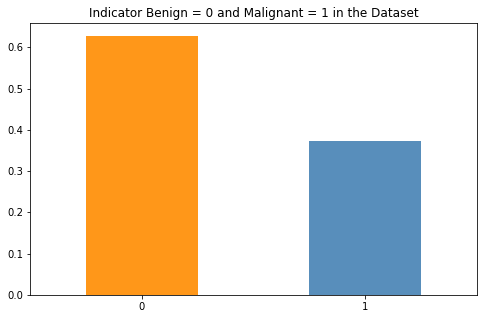

In [9]:
fig = plt.figure(figsize = (8,5))
train[1].value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Indicator Benign = 0 and Malignant = 1 in the Dataset')
plt.show()

In [10]:
train.dropna(inplace=True)

In [11]:
train.shape

(569, 31)

In [12]:
Type = 'center_scaling'

In [13]:
# Type = 'normalizing'

In [14]:
X = np.array(train.drop(columns=[1], inplace = False))

In [15]:
X.shape

(569, 30)

In [16]:
labels = np.array(train[1])

In [17]:
labels.shape

(569,)

In [18]:
D_train = labels[:500]
D_test = labels[500:]

In [19]:
X_train = X[:500]
X_test = X[500:]

In [20]:
train_processed, test_processed = pre_process(X_train, 
                                              X_test, 
                                              Type = Type) 
train_processed.shape, test_processed.shape

((500, 30), (69, 30))

In [21]:
n, d = train_processed.shape

In [22]:
D_train.shape, D_test.shape

((500,), (69,))

In [23]:
X_T = torch.tensor(train_processed, dtype = torch.float64)
Y_T = torch.tensor(np.zeros(train_processed.shape), dtype = torch.float64)
D_T = torch.tensor(D_train, dtype = torch.torch.int64)

In [24]:
X_test = torch.tensor(test_processed, dtype = torch.float64)
Y_test = torch.tensor(np.zeros(test_processed.shape), dtype = torch.float64)
D_test = torch.tensor(D_test, dtype = torch.torch.int64)

In [25]:
X_test.shape, X_T.shape

(torch.Size([69, 30]), torch.Size([500, 30]))

In [26]:
d = X_T.shape[1] 
k = d
n_labels = 2

In [27]:
model = ML(d, k, n_labels, 
           X_T, Y_T,  D_T, D_T, 
           X_test, Y_test, D_test, D_test, 
           Type = 'Laplace')

In [28]:
model.train(learning_rate = 3e-2, #3.5e-2 --> 98%
            n_iters = 20001, 
            decay = 0.95)

Starting Tau:  tensor([0.4047], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.6757308682359591
train accuracy with noise 0.61
train accuracy without noise 0.61
test accuracy with noise 0.7536231884057971
test accuracy without noise 0.7536231884057971
epoch 5000:
 norm of B.grad = 6.562566794404207e-05,
 loss = 0.07622272438623767
tensor([4.7831], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.984
train accuracy without noise 0.984
test accuracy with noise 0.9855072463768116
test accuracy without noise 0.9855072463768116
epoch 10000:
 norm of B.grad = 3.230506256410635e-05,
 loss = 0.06193007205902619
tensor([5.8368], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.984
train accuracy without noise 0.984
test accuracy with noise 0.9855072463768116
test accuracy without noise 0.9855072463768116
epoch 15000:
 norm of B.grad = 1.4241255084227881e-05,
 loss = 0.055638374833636615
tensor([6.4857], dtype=torch.float64, requires_grad=True)

In [29]:
I = (D_test == 1) # 'M': 1, 'B': 0
I.sum()

tensor(17)

In [30]:
X_test_M = X_test[I]
Y_test_M = Y_test[I]
D_test_M = D_test[I]

In [31]:
model.accuracy(X_test_M, Y_test_M, D_test_M)

1.0

In [32]:
J = (D_test == 0)
J.sum()

tensor(52)

In [33]:
X_test_B = X_test[J]
Y_test_B = Y_test[J]
D_test_B = D_test[J]

In [34]:
model.accuracy(X_test_B, Y_test_B, D_test_B)

0.9807692307692307

In [35]:
# X_T, Y_T,  D_T,

In [36]:
II = (D_T == 1) # 'M': 1, 'B': 0
II.sum()

tensor(195)

In [37]:
X_T_M = X_T[II]
Y_T_M = Y_T[II]
D_T_M = D_T[II]

In [38]:
model.accuracy(X_T_M, Y_T_M, D_T_M)

0.9692307692307692

In [39]:
JJ = (D_T == 0) # 'M': 1, 'B': 0
JJ.sum()

tensor(305)

In [40]:
X_T_B = X_T[JJ]
Y_T_B = Y_T[JJ]
D_T_B = D_T[JJ]

In [41]:
model.accuracy(X_T_B, Y_T_B, D_T_B)

0.9967213114754099

In [42]:
M = (model.B @ model.B.T).detach().numpy()

In [43]:
_, eigs, _ = LA.svd(M, full_matrices=False)

In [44]:
eigs

array([2.16323390e+01, 4.84510191e-09, 1.60295465e-10, 1.21488424e-10,
       8.98846694e-11, 6.88836519e-11, 6.00472077e-11, 4.94499951e-11,
       4.77041637e-11, 4.35888184e-11, 3.87857189e-11, 3.52636463e-11,
       2.93353567e-11, 2.74390412e-11, 2.60636059e-11, 1.86738994e-11,
       1.68680267e-11, 1.15491790e-11, 9.63048770e-12, 7.64471967e-12,
       5.97638193e-12, 4.28018476e-12, 2.85136306e-12, 2.40857824e-12,
       1.74826655e-12, 7.56140898e-13, 2.86514050e-13, 6.43857042e-14,
       6.30596279e-15, 2.15760864e-15])

### Cross validation

In [45]:
X = np.array(train.drop(columns=[1], inplace = False))
labels = np.array(train[1])

In [46]:
N_I = N_J = N_II = N_JJ = 0

Model_history = []

Train_accuracy = []
Test_accuracy = [] 

B_Train_accuracy = []
M_Train_accuracy = []

B_Test_accuracy = []
M_Test_accuracy = []

n = len(labels)

for _ in range(10):
    I = list(range(n))
    np.random.shuffle(I)
    X_train = X[I][:450]
    X_test = X[I][450:]
    D_train = labels[I][:450]
    D_test = labels[I][450:]
    train_processed, test_processed = pre_process(X_train, 
                                                  X_test, 
                                                  Type = Type) 
    train_processed.shape, test_processed.shape
    X_T = torch.tensor(train_processed, dtype = torch.float64)
    Y_T = torch.tensor(np.zeros(train_processed.shape), dtype = torch.float64)
    D_T = torch.tensor(D_train, dtype = torch.torch.int64)
    
    X_test = torch.tensor(test_processed, dtype = torch.float64)
    Y_test = torch.tensor(np.zeros(test_processed.shape), dtype = torch.float64)
    D_test = torch.tensor(D_test, dtype = torch.torch.int64)
    model = ML(d, k, n_labels, 
               X_T, Y_T,  D_T, D_T, 
               X_test, Y_test, D_test, D_test, 
               Type = 'Laplace')
    model.train(learning_rate = 3.5e-2, #3.5e-2 --> 98%
                n_iters = 20001, 
                decay = 0.95)
    
    Model_history.append(model)
    
    Train_accuracy.append(model.accuracy(X_T, Y_T, D_T))
    Test_accuracy.append(model.accuracy(X_test, Y_test, D_test)) 
    
    
    
    I = (D_T == 1) # M = 1 
    N_I += sum(I)
    
    J = (D_T == 0) # B = 0 
    N_J += sum(J)
    
    X_T_M = X_T[I]
    Y_T_M = Y_T[I]
    D_T_M = D_T[I]
    
    X_T_B = X_T[J]
    Y_T_B = Y_T[J]
    D_T_B = D_T[J]

    
    M_Train_accuracy.append((I.sum(), model.accuracy(X_T_M, Y_T_M, D_T_M))) 
    B_Train_accuracy.append((J.sum(), model.accuracy(X_T_B, Y_T_B, D_T_B)))
    
    
    
    II = (D_test == 1) # M = 1 
    N_II += sum(II)
    
    JJ = (D_test == 0) # B = 0 
    N_JJ += sum(JJ)
    
    X_test_M = X_test[II]
    Y_test_M = Y_test[II]
    D_test_M = D_test[II]
    
    X_test_B = X_test[JJ]
    Y_test_B = Y_test[JJ]
    D_test_B = D_test[JJ]
    
    M_Test_accuracy.append((II.sum(), model.accuracy(X_test_M, Y_test_M, D_test_M)))
    B_Test_accuracy.append((JJ.sum(), model.accuracy(X_test_B, Y_test_B, D_test_B)))
    

Starting Tau:  tensor([0.5197], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.6739452641888318
train accuracy with noise 0.6266666666666667
train accuracy without noise 0.6266666666666667
test accuracy with noise 0.6302521008403361
test accuracy without noise 0.6302521008403361
epoch 5000:
 norm of B.grad = 5.005079646919177e-05,
 loss = 0.05965927060288434
tensor([5.0223], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.9866666666666667
train accuracy without noise 0.9866666666666667
test accuracy with noise 0.9747899159663865
test accuracy without noise 0.9747899159663865
epoch 10000:
 norm of B.grad = 1.9348954226290288e-05,
 loss = 0.04695896932266451
tensor([6.1295], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.9911111111111112
train accuracy without noise 0.9911111111111112
test accuracy with noise 0.9747899159663865
test accuracy without noise 0.9747899159663865
epoch 15000:
 norm of B.grad = 1.1381915459999138e-05,
 loss

In [47]:
train_accuracy = sum(Train_accuracy)/10
test_accuracy = sum(Test_accuracy)/10

b_train_accuracy = 0
b_test_accuracy = 0

m_train_accuracy = 0
m_test_accuracy = 0

In [48]:
train_accuracy, test_accuracy 

(0.990888888888889, 0.9747899159663864)

In [49]:
for i in range(10):
    len_, acc_ = M_Train_accuracy[i]
    m_train_accuracy += (len_*acc_/N_I) 
    
    len_, acc_ = B_Train_accuracy[i]
    b_train_accuracy += (len_*acc_/N_J)
    
    len_, acc_ = M_Test_accuracy[i]
    m_test_accuracy += (len_*acc_/N_II) 
    
    len_, acc_ = B_Test_accuracy[i]
    b_test_accuracy += (len_*acc_/N_JJ)

In [50]:
m_train_accuracy, b_train_accuracy, m_test_accuracy, b_test_accuracy

(tensor(0.9792), tensor(0.9979), tensor(0.9588), tensor(0.9841))

In [51]:
C = np.cov(train_processed.T)
U_c, D_C, V_c = LA.svd(C, full_matrices = False)
D_C

array([3.54284715e-01, 1.17895281e-01, 4.73600170e-02, 4.22168486e-02,
       2.86745637e-02, 1.95555134e-02, 1.00000405e-02, 8.82168012e-03,
       6.76907744e-03, 6.30084735e-03, 5.51844358e-03, 4.50675880e-03,
       4.30119605e-03, 3.60671210e-03, 1.75541012e-03, 1.60760990e-03,
       1.06248851e-03, 8.80933691e-04, 8.37090769e-04, 6.32526126e-04,
       5.95614080e-04, 5.09272884e-04, 3.36736857e-04, 3.07137230e-04,
       2.98698158e-04, 2.30465116e-04, 1.26245260e-04, 3.73081661e-05,
       1.62411600e-05, 3.99942100e-06])

In [52]:
sqrt_C_inv = U_c @ np.diag(np.sqrt(D_C)**-1) @ V_c
sqrt_C = U_c @ np.diag(np.sqrt(D_C)) @ V_c

In [53]:
train_processed_normal = train_processed @ sqrt_C_inv

In [54]:
test_processed_normal = test_processed @ sqrt_C_inv

In [55]:
D_T = np.array(labels[:450])
D_test = np.array(labels[450:])

X_T = torch.tensor(train_processed, dtype = torch.float64)
Y_T = torch.tensor(np.zeros(train_processed.shape), dtype = torch.float64)
D_T = torch.tensor(D_train, dtype = torch.torch.int64)

X_test = torch.tensor(test_processed, dtype = torch.float64)
Y_test = torch.tensor(np.zeros(test_processed.shape), dtype = torch.float64)
D_test = torch.tensor(D_test, dtype = torch.torch.int64)

In [56]:
model_normal = ML(d, k, n_labels, 
           X_T, Y_T,  D_T, D_T, 
           X_test, Y_test, D_test, D_test, Type = 'Logistic')

In [57]:
model_normal.train(learning_rate = 1.5e-3, 
            n_iters = 15001, 
            decay = 0.95)

Starting Tau:  tensor([0.2214], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.6702332951985358
train accuracy with noise 0.6311111111111111
train accuracy without noise 0.6311111111111111
test accuracy with noise 0.773109243697479
test accuracy without noise 0.773109243697479
epoch 5000:
 norm of B.grad = 0.011075210523326029,
 loss = 0.6544306689769225
tensor([0.4847], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.6311111111111111
train accuracy without noise 0.6311111111111111
test accuracy with noise 0.773109243697479
test accuracy without noise 0.773109243697479
epoch 10000:
 norm of B.grad = 0.007243617607066889,
 loss = 0.3433915973511718
tensor([1.3164], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.9466666666666667
train accuracy without noise 0.9466666666666667
test accuracy with noise 0.5630252100840336
test accuracy without noise 0.5630252100840336
epoch 15000:
 norm of B.grad = 0.002615294868978116,
 loss = 0.249279